# Time Series Models

## Importing Necessary Libraries

In [1]:
import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

#For date-time
from datetime import datetime
from datetime import timedelta
import math



In [2]:
pd.options.display.max_columns=100 # to see columns 

In [3]:
df = pd.read_csv('data/train.csv')

In [4]:
df.head() # to see my data

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0.0


In [5]:
df["date"] = pd.to_datetime(df["date"]) #changing data to datetime for decomposing

In [6]:
df.set_index('date', inplace=True) #seting date as index

# Plotting Sales

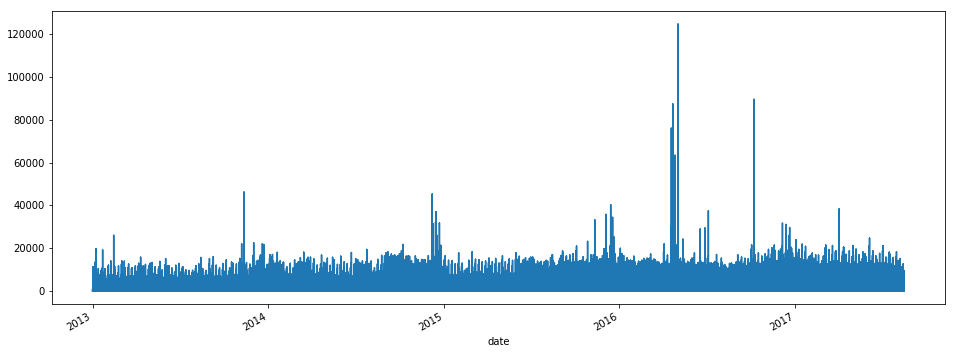

In [7]:
plt.figure(figsize=(16,6))
df['sales'].plot()
plt.show()

In this data, there are lots of same data values. So, I will collect them together as weekly.

In [8]:
df_week = df.resample('W').mean() #resample data as weekly

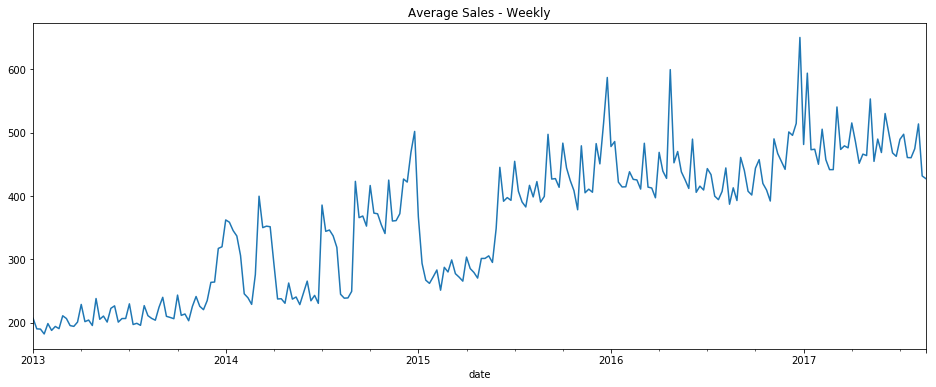

In [9]:
plt.figure(figsize=(16,6))
df_week['sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

With the collecting data as weekly, I can see average sales clearly. To see monthly pattern , I resampled my data to monthly also.

In [10]:
df_month = df.resample('MS').mean() # resampling as monthly

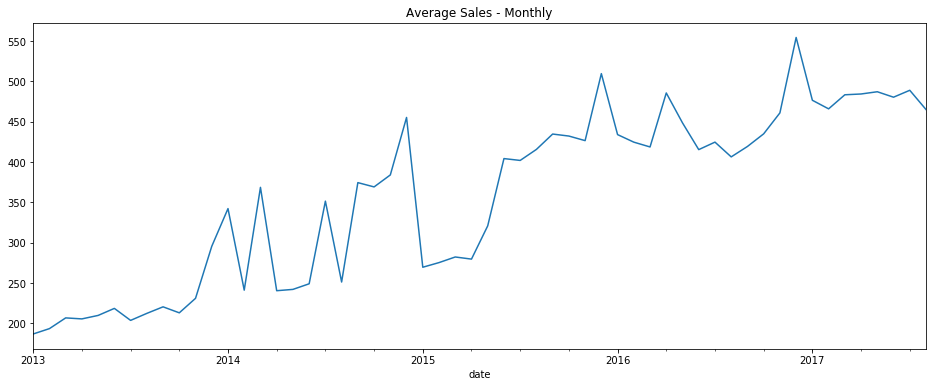

In [11]:
plt.figure(figsize=(16,6))
df_month['sales'].plot()
plt.title('Average Sales - Monthly')
plt.show()

# To Observe 2-weeks Rolling Mean and Std

My data is non-stationary. So, I will try to find more stationary version on it. 

In [12]:
# finding 2-weeks rolling mean and std
roll_mean = df_week['sales'].rolling(window=2, center=False).mean()
roll_std = df_week['sales'].rolling(window=2, center=False).std()

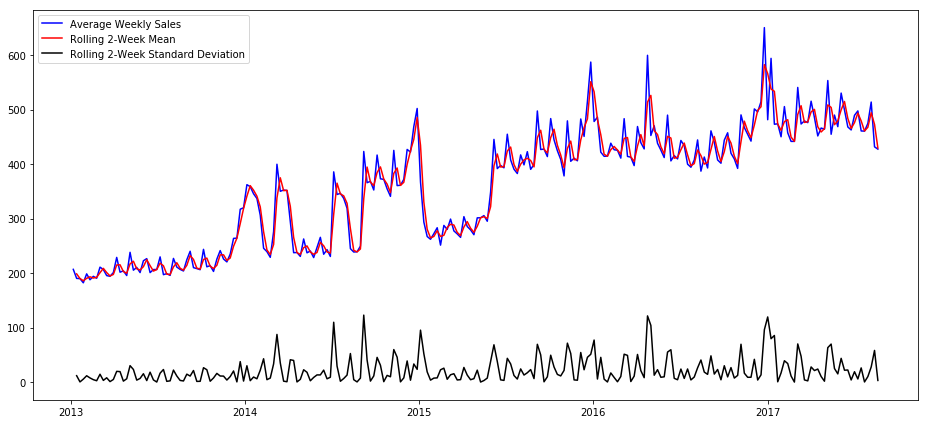

In [13]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week['sales'], color='blue',label='Average Weekly Sales')
ax.plot(roll_mean, color='red', label='Rolling 2-Week Mean')
ax.plot(roll_std, color='black', label='Rolling 2-Week Standard Deviation')
ax.legend()
fig.tight_layout()

# Adfuller Test to Make Sure

From test and my observations my data is not stationary. So, I will try to find more stationary version of it.

# Train - Test Split of Weekly Data

To take train-test splits continuosly, I split them manually, not random.

In [15]:
train_data = df_week[:int(0.7*(len(df_week)))] 
test_data = df_week[int(0.7*(len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (169, 4)
Test: (73, 4)


In [16]:
target = "sales"
used_cols = [c for c in df_week.columns.to_list() if c not in [target]] # all columns except price

# assigning train-test X-y values

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

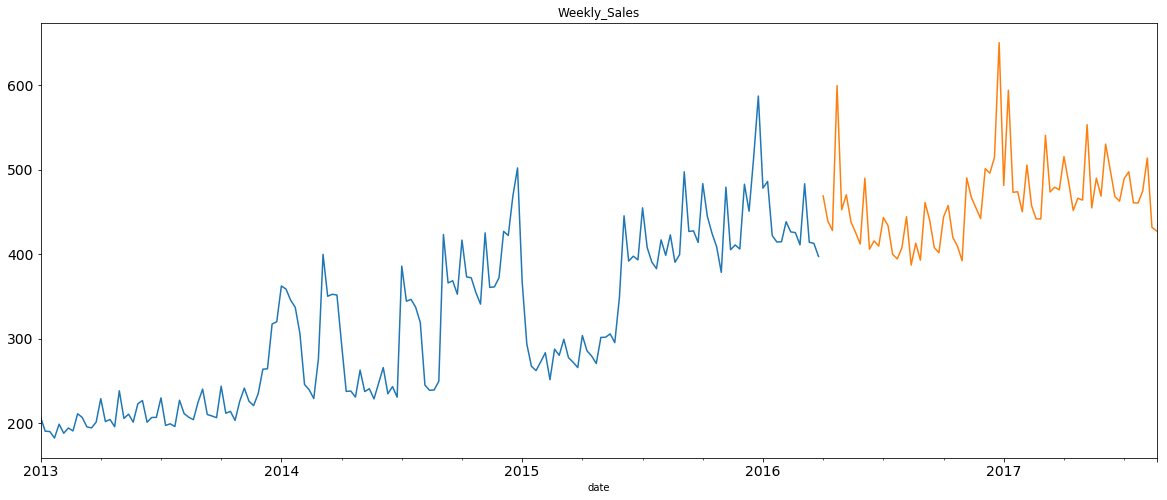

In [17]:
train_data['sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

Blue line represents my train data, yellow is test data.

# Decomposing Weekly Data to Observe Seasonality

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA


In [44]:
decomposed = seasonal_decompose(df_week['sales'].interpolate())


<Figure size 432x288 with 0 Axes>

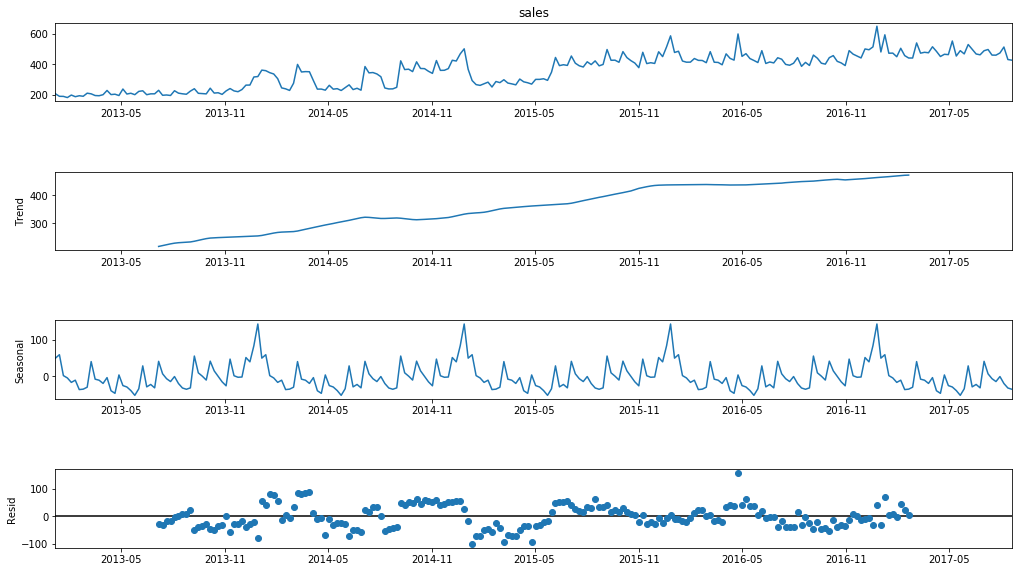

In [45]:

fig = plt.figure()  
fig = decomposed.plot()  
fig.set_size_inches(16, 9)

Yukarıdaki grafiklerden her 20 adımda bir mevsimsellik başlangıç noktasına yakınsar. Bu, modelimi ayarlamama yardımcı oluyor.

Verileri Daha Durağan Hale Getirmeye Çalışmak
Şimdi verilerimi daha durağan hale getirmeye çalışacağım. Bunu yapmak için, farklılaştırılmış, günlüğe kaydedilmiş ve kaydırılmış verilerle modeli deneyeceğim.

## 1. Difference

In [46]:
df_week_diff = df_week['sales'].diff().dropna() #creating difference values

In [47]:
# taking mean and std of differenced data
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()

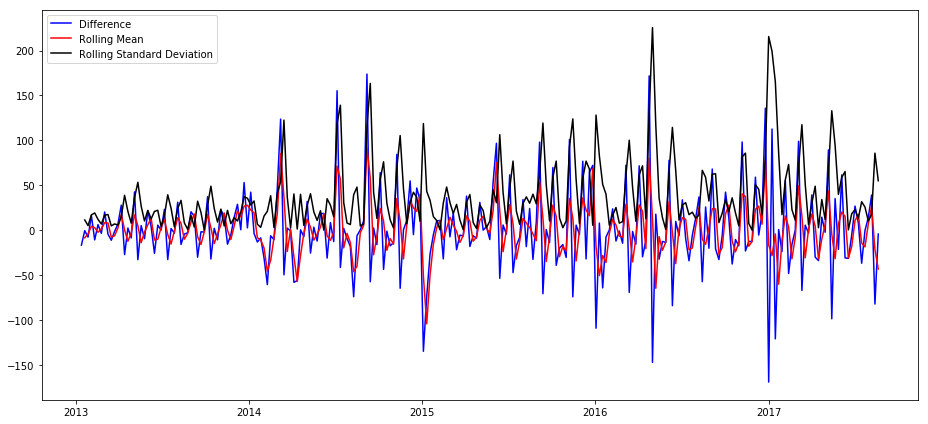

In [48]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

## 2.Shift

In [49]:
df_week_lag = df_week['sales'].shift().dropna() #shifting the data 

In [50]:
lag_roll_mean = df_week_lag.rolling(window=2, center=False).mean() 
lag_roll_std = df_week_lag.rolling(window=2, center=False).std()

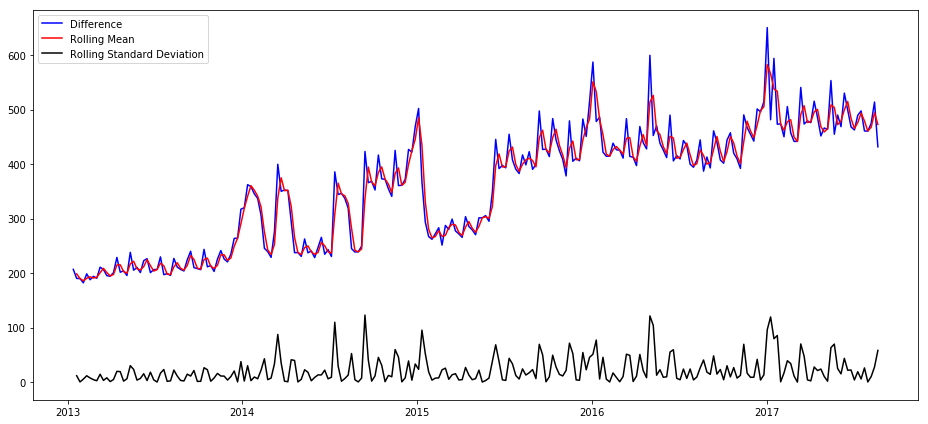

In [51]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_lag, color='blue',label='Difference')
ax.plot(lag_roll_mean, color='red', label='Rolling Mean')
ax.plot(lag_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

## 3.Log

In [52]:
logged_week = np.log1p(df_week['sales']).dropna() #taking log of data

In [53]:
log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()

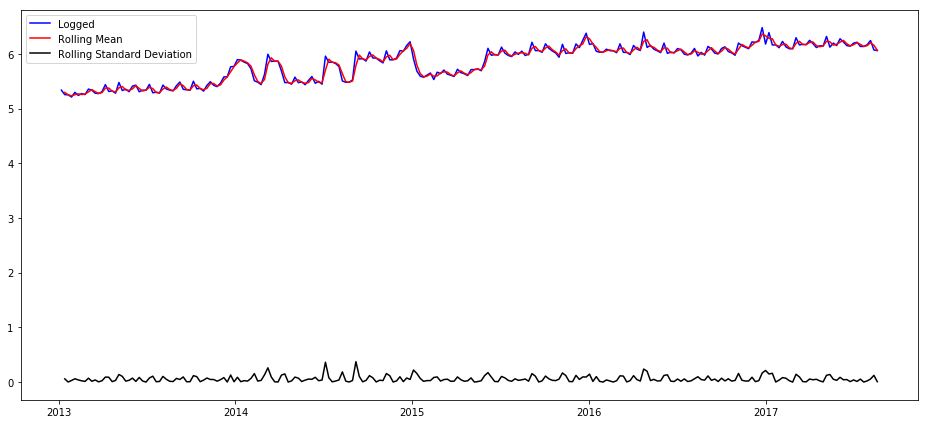

In [54]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='blue',label='Logged')
ax.plot(log_roll_mean, color='red', label='Rolling Mean')
ax.plot(log_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

# Auto-ARIMA MODEL

Verilerimi herhangi bir değişiklik yapmadan denedim, daha sonra verilerin log ve fark versiyonunu kaydırarak denedim. Farklılaştırılmış veriler en iyi sonuçları verdi. Ben de farkı alıp bu verileri kullanmaya karar verdim.

### Train-Test Split

In [55]:
train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]

In [112]:
!pip install pyramid

You are using pip version 10.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [58]:
!pip install pmdarima

  Using cached https://files.pythonhosted.org/packages/19/7c/b48f477227e70230cb5130b531bcb6301dbb3f17ef17b0c3c7f48e5faa3f/pmdarima-1.8.4-cp37-cp37m-win_amd64.whl


You are using pip version 10.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [59]:
from pmdarima.arima import auto_arima
# train_data = train_data['Weekly_Sales']
# test_data = test_data['Weekly_Sales']

model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1729.085, Time=0.32 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1722.201, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1723.535, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=1717.156, Time=0.13 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1718.640, Time=0.18 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1722.868, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1713.167, Time=0.28 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1724.776, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=172

ARIMA(maxiter=200, order=(1, 0, 4), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

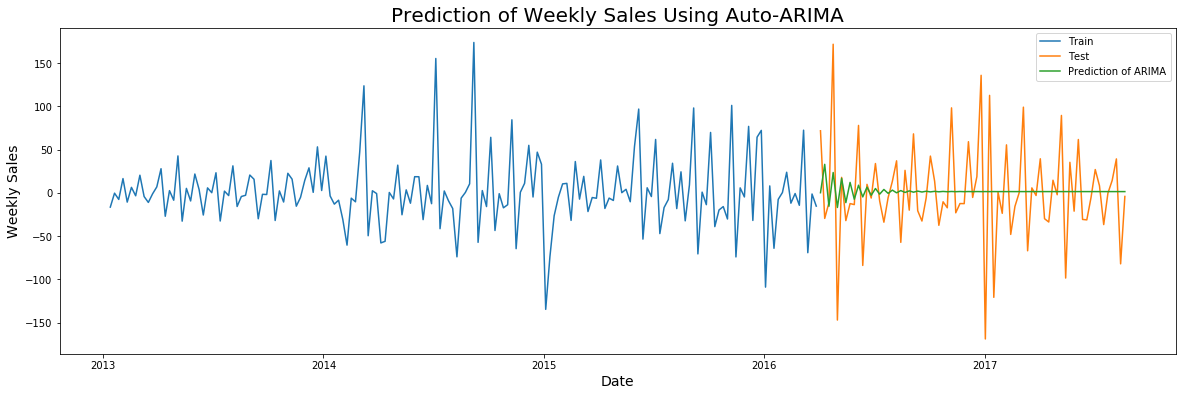

In [61]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

## ÜstelDüzeltme
Verilerime göre uygun Holt-Winters modellerini kontrol ettim. Üstel Düzeltme, veriler trend olduğunda kullanılır ve trendi düzleştirir. Sönümlü trend yöntemi bir sönümleme parametresi ekler, böylece trend gelecekte sabit bir değere yakınsar.

Fark verilerimin bazı eksi ve sıfır değerleri var, bu yüzden çarpım yerine mevsimsel ve trend toplamını kullandım. Mevsimsel dönemler yukarıdaki ayrıştırılmış grafiklerden seçilmiştir. Modeli yinelemelerle ayarlamak çok zaman alıyor, bu yüzden modeli değiştirdim ve farklı parametreler için denedim ve en iyi parametreleri buldum ve bunları modele sığdırdım.

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  """


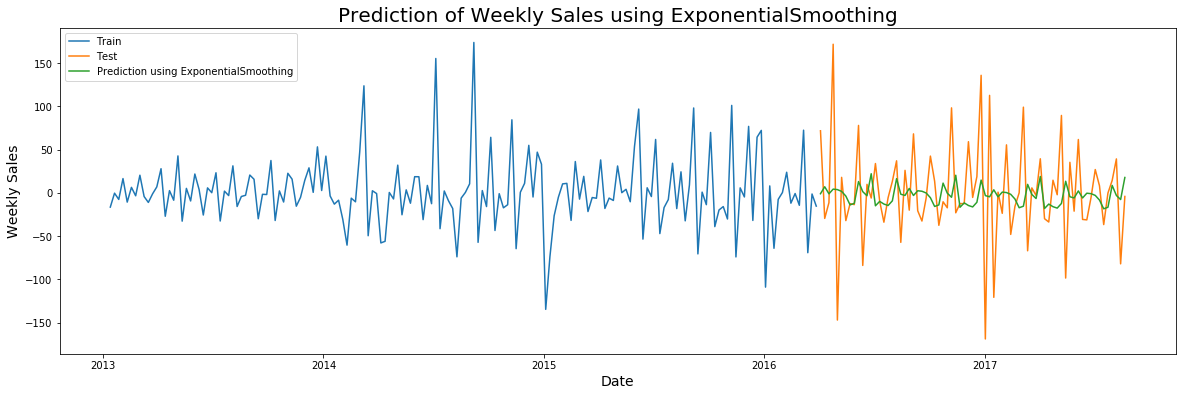

In [63]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt


model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.
y_pred = model_holt_winters.forecast(len(test_data_diff))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()


# Metric

In [72]:
def wmae_test(test, pred): # WMAE for test
    weights = X_test['onpromotion'].apply(lambda onpromotion:5 if onpromotion else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

In [73]:
wmae_test(test_data_diff, y_pred)

41.78275068061044

 Üstel Düzeltme Modeli ile verilerim için en iyi sonuçlar.

# ARCH

I also tried ARCH model with it's different versions like t/ARCH - g/ARCH etc. But, all of them did not give good results, so I did not continue to play with them.

In [87]:
!pip install arch

  Using cached https://files.pythonhosted.org/packages/41/88/fd4a2fc7da678aa05c1870dee512121c582b14717eb698131f772e0ef345/arch-5.0.1-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/5c/6c/94d8e520b20a2502e508e1c558f338061cf409cbee78fd6a3a5c6ae812bd/property_cached-1.6.4-py2.py3-none-any.whl


You are using pip version 10.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [89]:
from arch import arch_model
am = arch_model(train_data_diff, vol='GARCH',power=1,o=1)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     35,   Neg. LLF: 845.7666340799451
Iteration:     10,   Func. Count:     67,   Neg. LLF: 844.6551128216008
Optimization terminated successfully    (Exit mode 0)
            Current function value: 844.6534968609988
            Iterations: 15
            Function evaluations: 97
            Gradient evaluations: 14
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:                  sales   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -844.653
Distribution:                  Normal   AIC:                           1699.31
Method:            Maximum Likelihood   BIC:                           1714.93
                                        No. Observations:                  168
Date:                Sat, Nov 06 2021   Df Residuals:                      167
Time:          

Bu proje için en iyi sonucum 844'dir. Satış miktarlarına göre bu değer kabaca %4-5 civarında bir hatadır. Ortalama satışlarımızı alıp 844 hata yüzdesini alırsak kabaca %4-5 veriyor.